# Trait map generation from point data

...blabla


## Assignments
...

In [1]:
import pandas as pd
import numpy as np
import rasterio
import rasterio as rio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import os
import matplotlib.pyplot as plt
from typing import Union
import glob
import rioxarray

In [2]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Load data

In [3]:
# Load sPlot Data
sPlot = pd.read_csv('data/cwm_loc.csv')
sPlot.head()

C:\Users\teja\AppData\Local\Temp\ipykernel_28428\477925801.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  sPlot = pd.read_csv('data/cwm_loc.csv')


,PlotObservationID,GIVD_ID,Dataset,Continent,Country,Biome,Date_of_recording,Latitude,Longitude,Location_uncertainty,...,Seed length,Leaf dry mass per leaf fresh mass (LDMC),Leaf nitrogen (N) per area,Leaf nitrogen/phosphorus (N/P),Leaf delta15N,Seeds per rep. unit,Leaf fresh mass,Stem conduit density,Dispersal unit length,Conduit element length
0,16,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,1.046333,-1.150683,0.024882,1.874128,-0.264750,5.633945,-4.387745,3.483073,1.470741,5.859517
1,17,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,1.046333,-1.150683,0.024882,1.874128,-0.264750,5.633945,-4.387745,3.483073,1.470741,5.859517
2,18,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,1.046333,-1.150683,0.024882,1.874128,-0.264750,5.633945,-4.387745,3.483073,1.470741,5.859517
3,20,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,0.126305,-1.325711,0.107715,1.999404,-0.076209,3.036499,-4.124691,5.337666,0.252902,6.570591
4,22,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,0.118110,-1.376588,0.122927,2.036662,0.073539,3.451333,-3.968128,5.380727,0.242525,6.558434


In [4]:
# Load igbif Data
gbif = pd.read_csv('data/gbif_TRY_log.csv')
gbif.head()


,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,1831133852,34.817678,-115.642178,2017-05-01T04:27:23,Cylindropuntia ramosissima (Engelm.) F.M.Knuth,Plantae,Tracheophyta,Caryophyllales,Cactaceae,Cylindropuntia,...,1.371194,1.115537,3.966075,6.295767,7.358397,8.514826,6.281792,6.654385,5.416932,1.954091
1,2028476084,41.763906,-71.234208,2019-03-17T21:15:57,Juniperus virginiana L.,Plantae,Tracheophyta,Pinales,Cupressaceae,Juniperus,...,3.286208,2.560323,2.227021,5.956809,6.769252,8.687479,4.312630,3.386785,3.820388,0.470929
2,2963846153,45.439163,-73.290246,2020-10-29T08:11:33,Phragmites australis subsp. australis,Plantae,Tracheophyta,Poales,Poaceae,Phragmites,...,0.964195,1.120304,3.856287,5.627448,6.630769,10.415975,6.842373,8.032238,7.934354,0.748403
3,2826220632,57.744264,60.278176,2020-07-29T19:25:59,Sanguisorba officinalis L.,Plantae,Tracheophyta,Rosales,Rosaceae,Sanguisorba,...,0.255116,1.076163,5.241331,5.982212,6.849258,8.816813,7.842883,7.349957,7.776992,0.743314
4,1883535355,34.858802,-80.870275,2018-07-15T23:33:31,Solanum carolinense L.,Plantae,Tracheophyta,Solanales,Solanaceae,Solanum,...,1.064204,1.504335,3.695844,6.040066,6.453957,7.989861,7.833045,7.577830,8.182855,1.580165


## Define the functions for rasterization

A function to rasterize the point data

In [6]:
def rasterize_points(
    points: np.ndarray, res: Union[int, float], bbox: tuple
) -> np.ndarray:
    """Rasterize points into a grid with a given resolution.

    Args:
        points (np.ndarray): Points to rasterize, with columns (x, y, value) (for
            geographic coordinates, use (lon, lat, value))
        res (Union[int, float]): Resolution of the grid
        bbox (tuple): Bounding box of the grid

    Returns:
        np.ndarray: Rasterized grid
    """
    width = int((bbox[2] - bbox[0]) / res)
    height = int((bbox[3] - bbox[1]) / res)

    rast = np.full((height, width), np.nan, dtype=np.float32)
    count_array = np.full((height, width), np.nan, dtype=np.float32)

    for x, y, value in points:
        col = int((x - bbox[0]) / res)
        row = int((bbox[3] - y) / res)
        if np.isnan(rast[row, col]):
            rast[row, col] = value
            count_array[row, col] = 1
        else:
            rast[row, col] += value
            count_array[row, col] += 1

    # Avoid division by zero
    count_array = np.nan_to_num(count_array, nan=1)

    # Calculate the average
    rast = rast / count_array

    return rast

A function to write the rasters to disk

In [7]:

def write_raster(
    raster: np.ndarray, res: Union[int, float], bbox: tuple, filename: os.PathLike
) -> None:
    """Write a raster to a GeoTIFF file.

    Args:
        raster (np.ndarray): Raster matrix to write
        res (Union[int, float]): Resolution of the raster
        bbox (tuple): Bounding box of the raster
        filename (os.PathLike): Path to the output file
    """
    width = int((bbox[2] - bbox[0]) / res)
    height = int((bbox[3] - bbox[1]) / res)

    with rio.open(
        filename,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        nodata=0,
        count=1,
        dtype=rio.float32,
        crs="EPSG:4326",
        transform=from_origin(bbox[0], bbox[3], res, res),
        compress="zstd",
    ) as dst:
        dst.write(raster, 1)

Let´s plot the data for a test:

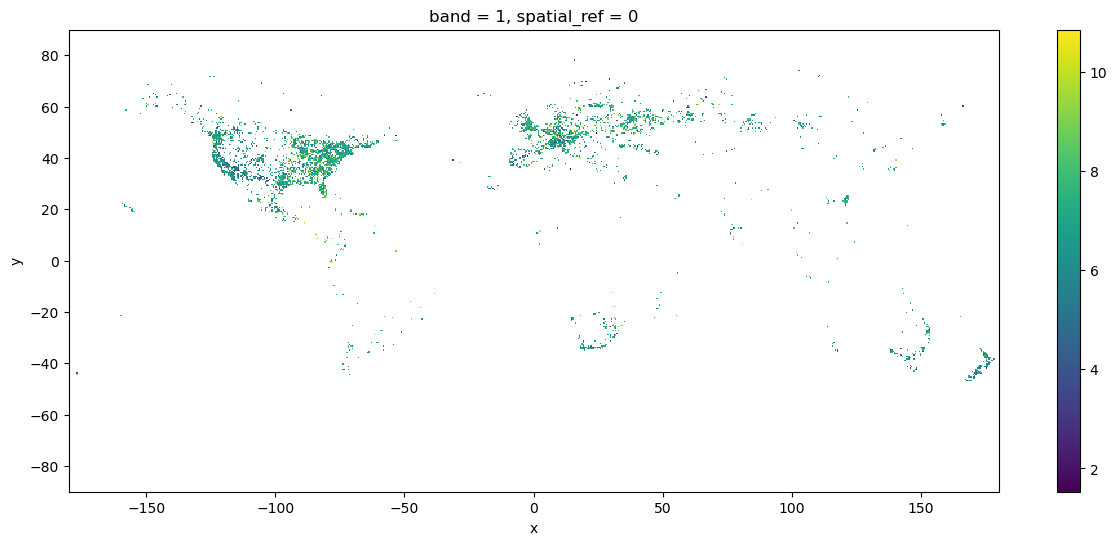

In [27]:
test = rasterize_points(gbif[["decimalLongitude", "decimalLatitude", "Leaf Area (all undefined)"]].values, 0.5, (-180, -90, 180, 90))
os.makedirs("temp", exist_ok=True)
write_raster(test, 0.5, (-180, -90, 180, 90), "temp/test_raster_export.tif")
test = rioxarray.open_rasterio("temp/test_raster_export.tif")


plt.figure(figsize=(15, 6))
test.plot()

## Automate the process for all traits

Create maps for all traits in sPlot

In [9]:
# select the trait colums of sPlot
traits = sPlot.columns[50:]
# define a directory for exporting the trait maps
target_dir = "exports/trait_maps_splot"
os.makedirs(target_dir, exist_ok=True)

for trait in traits:
    raster = rasterize_points(sPlot[["Longitude", "Latitude", trait]].values, 0.5, (-180, -90, 180, 90))
    # remove special characters before using the trait name as a filename
    trait = trait.replace('(', '_').replace(')', '_').replace('/', '_').replace('.', '_').replace(' ', '_')
    write_raster(raster, 0.5, (-180, -90, 180, 90), f"{target_dir}/sPlot_{trait}.tif")

Create maps for all traits in gbif

In [10]:
# select the trait colums of sPlot
traits = gbif.columns[15:]
# define a directory for exporting the trait maps
target_dir = "exports/trait_maps_gbif"
os.makedirs(target_dir, exist_ok=True)

for trait in traits:
    raster = rasterize_points(gbif[["decimalLongitude", "decimalLatitude", trait]].values, 0.5, (-180, -90, 180, 90))
    # remove special characters before using the trait name as a filename
    trait = trait.replace('(', '_').replace(')', '_').replace('/', '_').replace('.', '_').replace(' ', '_')
    write_raster(raster, 0.5, (-180, -90, 180, 90), f"{target_dir}/gbif_{trait}.tif")

## Evaluate GBIF-based trait maps with splot:

In [11]:
# open trait maps with rioxarray and calculate the correlation between the trait maps

gbif_path = glob.glob('exports/trait_maps_gbif/*height*.tif')
gbif_rast = rioxarray.open_rasterio(gbif_path[0])

splot_path = glob.glob('exports/trait_maps_splot/*height*.tif')
splot_rast = rioxarray.open_rasterio(splot_path[0])

correlation: 0.3076151417649498


Text(0, 0.5, 'sPlot')

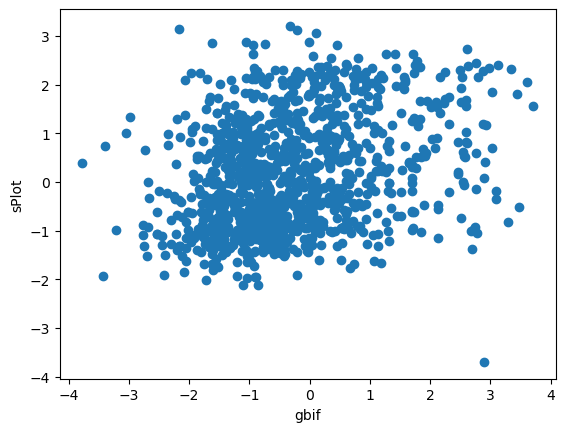

In [28]:
gbif_val = gbif_rast.values.flatten()
splot_val = splot_rast.values.flatten()

nan_gbif = np.where(np.isnan(gbif_val))
nan_splot = np.where(np.isnan(splot_val))

nan_values = np.concatenate((nan_gbif, nan_splot), axis=1)

gbif_val = np.delete(gbif_val, nan_values)
splot_val = np.delete(splot_val, nan_values)

print("correlation:", np.corrcoef(gbif_val, splot_val)[0, 1])
plt.scatter(gbif_val, splot_val)
plt.xlabel("gbif")
plt.ylabel("sPlot")